In [196]:
from datasets import load_dataset, Value, ClassLabel
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [197]:
# # Only need to run this once to download the dataset

# # Load dataset and take a random sample of 100,000 rows
# sample_size = 100000

# ds = load_dataset('free-law/Caselaw_Access_Project', streaming=True, split='train')

# # Estimated rows (from HuggingFace)
# total_size = 4284276

# # Calculate sampling probability
# sample_size = 100_000
# sampling_prob = sample_size / total_size

# # Take reservoir sample
# sampled_data = []
# for i, example in tqdm(enumerate(ds)):
#     if random.random() < sampling_prob:
#         sampled_data.append(example)
    
#     # Print progress periodically
#     if i % 100000 == 0:
#         print(f"Processed {i} examples, currently have {len(sampled_data)} samples")

In [41]:
# Convert to pandas df
df = pd.DataFrame(sampled_data)

In [42]:
# Convert appropriate columns to numeric
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        continue

In [43]:
df.shape

(156374, 20)

Save data sample for future use without having to load again.

In [198]:
# Pick up from here
# df.to_parquet('../data/caselaw_sample.parquet')
df = pd.read_parquet('../data/caselaw_sample.parquet')

### Exploratory analysis of the data.

#### Word Counts

In [199]:
# Interested in word count statistics
df['word_count'].describe()

count    156374.000000
mean       1882.482567
std        2730.854813
min           5.000000
25%         228.000000
50%        1128.000000
75%        2494.000000
max      112016.000000
Name: word_count, dtype: float64

In [200]:
# Mean is around 1800 words, median is around 1100 words. Choosing cutoff of 1200.
cutoff = 1200
df_filtered = df.query(f'word_count < {cutoff}')
df_filtered.shape

(80884, 20)

array([[<Axes: title={'center': 'word_count'}>]], dtype=object)

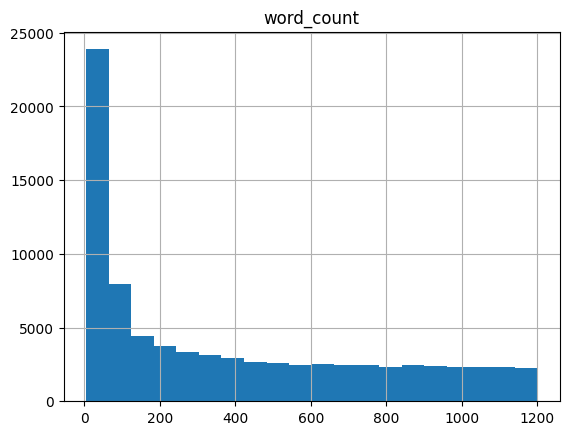

In [201]:
df_filtered.hist(column='word_count', bins=20)

#### Court Types

In [202]:
# Look into the different courts that are present, statistics
court_counts = df_filtered[['id', 'court']].groupby('court').count().sort_values('id', ascending=False)
court_counts.query('id > 500')

,id
court,
"New York Supreme Court, Appellate Division",15396
Supreme Court of the United States,7553
Florida District Court of Appeal,4842
Louisiana Supreme Court,3787
New York Court of Appeals,1898
United States Court of Appeals for the Ninth Circuit,1849
Court of Appeals of Georgia,1448
Supreme Court of Ohio,1438
United States Court of Appeals for the Fifth Circuit,1350


Types of courts seem to include:
- Supreme Court of United States
- United States Court of Appleas (for the ...th Circuit)
- United States Customs Court
- Supreme Court of [State]
- Appellate Court / Court of Appeals / Court of Errors and Appeals
- Superior Court
- New York Supreme Court, General Term; New York Supreme Court, New York Supreme Court, Appllate Division
- Court of Claims
- United States Board of Tax Appeals
- District Court
- Other





In [203]:
def court_type(court):
    court = court.lower()
    if 'supreme court of the united states' in court:
        return 'Supreme Court of the United States'
    if any(['court of appeals' in court, 'appellate court' in court, 'court of errors and appeals' in court] ):
        return 'Court of Appeals'
    if 'supreme' in court:
        return 'State Supreme Court'
    if 'district court' in court:
        return 'District Court'
    if 'superior' in court:
        return 'Superior Court'
    if 'court of claims' in court:
        return 'Court of Claims'
    if 'tax' in court:
        return 'Tax Court'
    if 'customs' in court:
        return 'Customs Court'
    return 'Other'

df_filtered.loc[:, 'court_type'] = df_filtered.loc[:, 'court'].apply(court_type)
df_filtered[['court', 'court_type']]

/var/folders/z_/cywsxk4n26911n3csczkd0gc0000gn/T/ipykernel_83216/2222923943.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'court_type'] = df_filtered.loc[:, 'court'].apply(court_type)


,court,court_type
8,Alaska Supreme Court,State Supreme Court
9,Alaska Supreme Court,State Supreme Court
10,Alaska Supreme Court,State Supreme Court
13,Alaska Supreme Court,State Supreme Court
22,Alaska Court of Appeals,Court of Appeals
...,...,...
156345,Supreme Court of Wyoming,State Supreme Court
156350,Supreme Court of Wyoming,State Supreme Court
156352,Supreme Court of Wyoming,State Supreme Court
156370,Supreme Court of Wyoming,State Supreme Court


court_type
State Supreme Court                   37651
Court of Appeals                      18455
Supreme Court of the United States     7553
District Court                         7393
Other                                  6483
Superior Court                         1560
Customs Court                          1041
Court of Claims                         520
Tax Court                               228
Name: count, dtype: int64


<Axes: title={'center': 'Court Type Counts'}, ylabel='Frequency'>

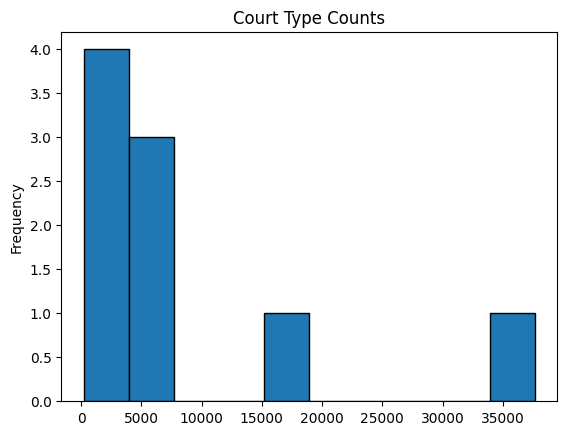

In [204]:
df_courttype_counts = df_filtered.loc[:, 'court_type'].value_counts()
print(df_courttype_counts)
df_courttype_counts.plot.hist(title='Court Type Counts', edgecolor='black')

#### Jurisdictions

In [205]:
# Look into the different jurisdictions that are present, statistics
jurisdiction_counts = df_filtered.loc[:, 'jurisdiction'].value_counts().sort_values(ascending=False)


<Axes: title={'center': 'Jurisdiction Counts'}, ylabel='Frequency'>

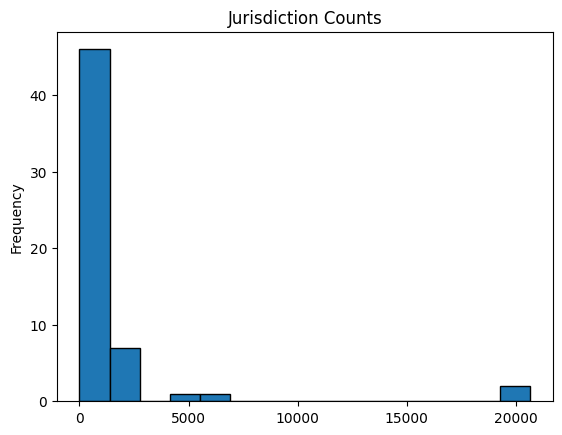

In [206]:
jurisdiction_counts.plot.hist(title='Jurisdiction Counts', bins=15, edgecolor='black')

We are omega unbalanced Jurisdictions. New York is the highest, even ahead of federal. Will definitely need to balance across states.

#### Balanced dataset creation

court_type_jurisdiction
State Supreme Court - New York                        17671
Court of Appeals - United States                       7989
Supreme Court of the United States - United States     7553
District Court - Florida                               5388
State Supreme Court - Louisiana                        3787
                                                      ...  
Tax Court - Indiana                                       1
Superior Court - Maryland                                 1
Other - Kentucky                                          1
Superior Court - Northern Mariana Islands                 1
District Court - Massachusetts                            1
Name: count, Length: 162, dtype: int64


<Axes: title={'center': 'Court Type - Jurisdiction Counts'}, ylabel='Frequency'>

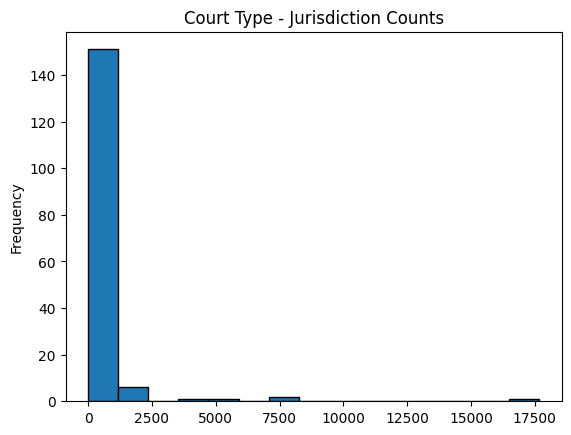

In [108]:
df_filtered.loc[:, 'court_type_jurisdiction'] = df_filtered.apply(lambda x: f"{x['court_type']} - {x['jurisdiction']}", axis=1)
df_courttype_jurisdiction_counts = df_filtered.loc[:, 'court_type_jurisdiction'].value_counts()
print(df_courttype_jurisdiction_counts)
df_courttype_jurisdiction_counts.plot.hist(title='Court Type - Jurisdiction Counts', bins=15, edgecolor='black')

<Axes: title={'center': 'Court Type - Jurisdiction Counts (Zoomed In)'}, ylabel='Frequency'>

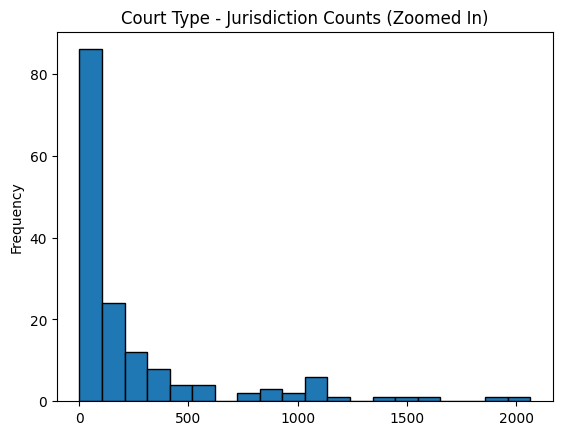

In [109]:
# Zoomed in histogram
df_courttype_jurisdiction_counts.loc[df_courttype_jurisdiction_counts < 2500].plot.hist(title='Court Type - Jurisdiction Counts (Zoomed In)', bins=20, edgecolor='black')

In [110]:
df_courttype_jurisdiction_counts.head()

court_type_jurisdiction
State Supreme Court - New York                        17671
Court of Appeals - United States                       7989
Supreme Court of the United States - United States     7553
District Court - Florida                               5388
State Supreme Court - Louisiana                        3787
Name: count, dtype: int64

In [111]:
# Exploring cutoffs
cutoffs = [10, 50, 100, 250, 500]
# Scaler used to estimate number of raw counts in full dataset
total_size = 4284276
scaler = total_size / df_filtered.shape[0]


for cutoff in cutoffs:
    print(f"Number of combos over {cutoff}: {df_courttype_jurisdiction_counts.loc[df_courttype_jurisdiction_counts > cutoff].shape[0]}")
    print(f"Number of combos under {cutoff}: {df_courttype_jurisdiction_counts.loc[df_courttype_jurisdiction_counts <= cutoff].shape[0]}")
    print(f"Estimated raw count above  {cutoff}: {int(round(df_courttype_jurisdiction_counts.loc[df_courttype_jurisdiction_counts > cutoff].sum() * scaler, -3))}")
    print(f"Estimated raw count below {cutoff}: {int(round(df_courttype_jurisdiction_counts.loc[df_courttype_jurisdiction_counts <= cutoff].sum() * scaler, -3))}")
    print(f"Estimated raw percent below {cutoff}: {round(df_courttype_jurisdiction_counts.loc[df_courttype_jurisdiction_counts <= cutoff].sum() * scaler / total_size * 100, 2)}")
    print('---------------------------------------------')

Number of combos over 10: 121
Number of combos under 10: 41
Estimated raw count above  10: 4276000
Estimated raw count below 10: 8000
Estimated raw percent below 10: 0.2
---------------------------------------------
Number of combos over 50: 95
Number of combos under 50: 67
Estimated raw count above  50: 4239000
Estimated raw count below 50: 45000
Estimated raw percent below 50: 1.06
---------------------------------------------
Number of combos over 100: 76
Number of combos under 100: 86
Estimated raw count above  100: 4162000
Estimated raw count below 100: 122000
Estimated raw percent below 100: 2.85
---------------------------------------------
Number of combos over 250: 47
Number of combos under 250: 115
Estimated raw count above  250: 3903000
Estimated raw count below 250: 381000
Estimated raw percent below 250: 8.89
---------------------------------------------
Number of combos over 500: 29
Number of combos under 500: 133
Estimated raw count above  500: 3577000
Estimated raw coun

Planning on using a cutoff of 10 as the "other" category in my sampler.

In [212]:
# Save the list of court type - jurisdiction combos with more than 10 counts
main = list(df_courttype_jurisdiction_counts[df_courttype_jurisdiction_counts > 10].index)
with open('../data/main_courttype_jurisdiction_combos.txt', 'w') as f:
    for item in main:
        f.write(f"{item}\n")

In [213]:
courttype_jurisdictions = main + ['Other']
len(courttype_jurisdictions)

122

# Make balanced, stratified sample of full data

In [236]:
ds = load_dataset('free-law/Caselaw_Access_Project', split='train')
wc_cutoff = 1200

In [238]:
ds = ds.remove_columns(['first_page', 'last_page', 'volume', 'last_updated', 'provenance', 'judges', 'parties', 'head_matter', 'char_count'])

In [239]:
ds = ds.filter(lambda x: x['word_count'] != '')

In [240]:
features = ds.features
new_features = features.copy()
new_features['word_count'] = Value("int64")
ds = ds.cast(new_features)

In [241]:
ds = ds.filter(lambda x: x['word_count'] < wc_cutoff)

Filter: 100%|██████████| 6678476/6678476 [02:50<00:00, 39237.68 examples/s] 


In [242]:
ds.column_names

['id',
 'name',
 'name_abbreviation',
 'decision_date',
 'docket_number',
 'citations',
 'reporter',
 'court',
 'jurisdiction',
 'word_count',
 'text']

In [244]:
def get_court_type(court):
    court = court.lower()
    if 'supreme court of the united states' in court:
        return 'Supreme Court of the United States'
    if any(['court of appeals' in court, 'appellate court' in court, 'court of errors and appeals' in court] ):
        return 'Court of Appeals'
    if 'supreme' in court:
        return 'State Supreme Court'
    if 'district court' in court:
        return 'District Court'
    if 'superior' in court:
        return 'Superior Court'
    if 'court of claims' in court:
        return 'Court of Claims'
    if 'tax' in court:
        return 'Tax Court'
    if 'customs' in court:
        return 'Customs Court'
    return 'Other'

with open('../data/main_courttype_jurisdiction_combos.txt', 'r') as f:
    main = f.read().splitlines()

def get_courttype_jurisdiction(example):
    court = example['court']
    jurisdiction = example['jurisdiction']
    court_type = get_court_type(court)
    combo = f"{court_type} - {jurisdiction}"
    if combo not in main:
        return 'Other'
    return combo

ds = ds.map(lambda x: {'court_type_jurisdiction': get_courttype_jurisdiction(x)})

Map: 100%|██████████| 3455806/3455806 [04:29<00:00, 12843.98 examples/s]


In [246]:
court_type_jurisdictions_unique = list(set(ds['court_type_jurisdiction']))
len(court_type_jurisdictions_unique)

122

In [248]:
new_features = ds.features.copy()
new_features['court_type_jurisdiction'] = ClassLabel(names=court_type_jurisdictions_unique)
ds = ds.cast(new_features)

Casting the dataset: 100%|██████████| 3455806/3455806 [00:21<00:00, 164530.47 examples/s]


In [250]:
# Shuffle the dataset, but write to disk using flatten_indices to speed up
ds = ds.shuffle(seed=42)


In [252]:
ds = ds.flatten_indices()

Flattening the indices: 100%|██████████| 3455806/3455806 [02:58<00:00, 19368.53 examples/s]


In [263]:
from collections import defaultdict

sample_target = 100_000 # Target size of sampled dataset
class_target = sample_target // len(court_type_jurisdictions_unique) # Target size of each class

samples_dict = defaultdict(int)
sampled_indices = []

def check_sample(cls, id):
    if samples_dict[cls] < class_target:
        samples_dict[cls] += 1
        sampled_indices.append(id)

ds.map(lambda x: check_sample(x['court_type_jurisdiction'], x['id']))

Map: 100%|██████████| 3455806/3455806 [01:04<00:00, 53171.55 examples/s]


Dataset({
    features: ['id', 'name', 'name_abbreviation', 'decision_date', 'docket_number', 'citations', 'reporter', 'court', 'jurisdiction', 'word_count', 'text', 'court_type_jurisdiction'],
    num_rows: 3455806
})

In [266]:
balanced_ds = ds.filter(lambda x: x['id'] in sampled_indices)

Filter: 100%|██████████| 3455806/3455806 [34:43<00:00, 1658.33 examples/s]


In [270]:
balanced_ds.shape

(97740, 12)

In [271]:
balanced_ds.to_parquet('../data/caselaw_balanced.parquet')

Creating parquet from Arrow format: 100%|██████████| 98/98 [00:05<00:00, 18.04ba/s]


311128820